In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
housing_full = pd.read_csv('data/Housing_data.csv')

In [4]:
housing_full.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Applying Preprocessing to the data to make it zero mean, unit variance

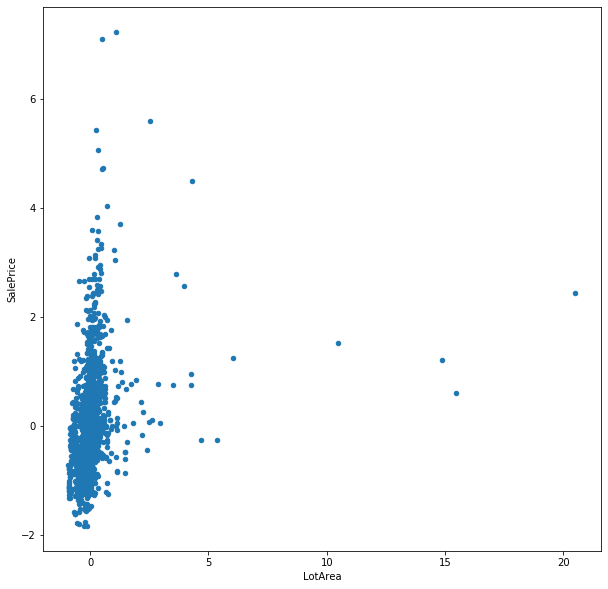

In [5]:
from sklearn.preprocessing import StandardScaler

df = housing_full[['LotArea', 'SalePrice']]
df = df.dropna()

cols = list(df.columns)

for column in cols:
    df[column] = StandardScaler().fit_transform(df[[column]])

df.plot.scatter(x=cols[0], y=cols[1], figsize=(10,10))

## Description of method

### First we train KDE on the dataset and then we need to determine the local gradients to move the points along. For that, we need to determine the grid that we sample the field accordingly. 

### Steps:

1. Determine the gird spacing for x axis and y axis: 
    1. For each axis, get the sorted list of coordinates
    2. We then take the difference of the first two values and use that as the grid spacing 
       (This is the minimum difference in the whole dataset - for that coordinate) 
    
   This ensures that the grid is fine enough to cover the gradients of each of the points. 
   Calculating the grid spacing this way makes this method general to all the datasets. 
 
2. Train a KDE model on the entire dataset
3. Get the sample of KDE density on the grid that we calculated above. 
4. Get the gradients of density over the entire grid
5. For each point in the dataset, get the local gradient vector and move that point in the direction opposite to the gradient vector 

### Calculate Density around each point using KDE

In [14]:
from sklearn.neighbors import LocalOutlierFactor, KernelDensity, NearestNeighbors

kde = KernelDensity(bandwidth=4)
# TODO: determine a method to make it generalizable (bandwidth)

kde.fit(df[cols])
# df['kde'] = kde.score_samples(df[cols])

KernelDensity(algorithm='auto', atol=0, bandwidth=4, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

### Determine the grid spacing

In [15]:
def get_grid_span(coordinate_list):
    '''
    Get the span and the grid spacing for the coordinate
    '''
    sort = sorted(coordinate_list)
    diff = sort[1]-sort[0]
    
    return np.arange(sort[0], sort[-1], diff)

In [22]:
x, y = cols[0], cols[1]

# Coordinate axis values
x, y = get_grid_span(df[x].tolist()),\
       get_grid_span(df[y].tolist())

# Constructing a grid using those axes 
xx, yy = np.meshgrid(x, y)

### Get the density over the grid

In [23]:
def get_density(x, y, kde):
    
    return -1/kde.score_samples(np.array([x, y]).reshape(1,-1))[0]

In [24]:
vec_dens = np.vectorize(get_density)

#### Run following cell to executhe that method


In [28]:
# z = vec_dens(xx, yy, kde)  

fig = plt.figure(figsize=(8,8))
plt.contourf(x,y,z, cmap='hot')
plt.colorbar()

KeyboardInterrupt: 

## This approach taking toooo much time. Coming up with another function to calculate gradient locally